[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Jouzel_and_Merlivat_1984/fig_8_9.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Jouzel_and_Merlivat_1984/fig_8_9.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Jouzel_and_Merlivat_1984/fig_8_9.ipynb)

# Comparison between saturation wrt. ice and effective saturation - based on  [Jouzel and Merlivat 1984](https://doi.org/10.1029/JD089iD07p11749) "_Deuterium and oxygen 18 in precipitation: Modeling of the isotopic effects during snow formation_"

figs 8 and 9

In [9]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [10]:
from matplotlib import pyplot
import numpy as np

from PySDM import Formulae
from PySDM_examples.Jouzel_and_Merlivat_1984.thermodynamic_profiles import ice_saturation_curve_4
from open_atmos_jupyter_utils import show_plot

In [11]:
ANY_NUMBER = 44

formulae= Formulae(
    latent_heat_vapourisation="Lowe2019",
    saturation_vapour_pressure="MurphyKoop2005",
    isotope_diffusivity_ratios="Stewart1975",
    isotope_kinetic_fractionation_factors="JouzelAndMerlivat1984",
    isotope_equilibrium_fractionation_factors="MerlivatAndNief1967+Majoube1970",
    diffusion_thermics="Neglect",
)
const = formulae.constants
svp = formulae.saturation_vapour_pressure
C2K = formulae.trivia.C2K
K2C = formulae.trivia.K2C

n_points = 100
T_0_50 = C2K(np.linspace(0.0, -50, n_points))

In [12]:
diffusivity_ratio = {}
alpha_eq = {}
alpha_kinetic = {}
isotopes = ("2H", "18O")
for isotope in isotopes:
    alpha_eq[isotope] = getattr(formulae.isotope_equilibrium_fractionation_factors, f'alpha_i_{isotope}')
    diffusivity_ratio[isotope] = getattr(formulae.isotope_diffusivity_ratios, f'ratio_{isotope}_heavy_to_light')

## Saturation wrt ice - comparison with effective saturation

In [13]:
pvs_ice = formulae.saturation_vapour_pressure.pvs_ice
pvs_water = formulae.saturation_vapour_pressure.pvs_water
pressure = ANY_NUMBER

D_light = formulae.diffusion_thermics.D(T=T_0_50, p=pressure)
Fk = formulae.drop_growth.Fk(
    T=T_0_50,
    K=formulae.diffusion_thermics.K(T=T_0_50, p=pressure),
    lv=formulae.latent_heat_vapourisation.lv(T_0_50)
) / const.rho_w * pvs_ice(T_0_50) / const.Rv / T_0_50 # TODO change A definition or call it differently


saturation_wrt_ice_at_RH100 = pvs_water(T_0_50) / pvs_ice(T_0_50)


eff_saturation_wrt_ice_at_RH100 = formulae.isotope_kinetic_fractionation_factors.effective_saturation(
    transfer_coefficient=formulae.isotope_kinetic_fractionation_factors.transfer_coefficient(
    D=D_light,
    Fk=Fk
),
    RH=saturation_wrt_ice_at_RH100
)

In [14]:
isotope_considered = '2H'
alpha_kinetic = formulae.isotope_kinetic_fractionation_factors.alpha_kinetic(
        alpha_equilibrium = alpha_eq[isotope_considered](T_0_50),
        D_ratio_heavy_to_light=diffusivity_ratio[isotope_considered](T_0_50),
        saturation = saturation_wrt_ice_at_RH100
    )

eff_alpha_kinetic = formulae.isotope_kinetic_fractionation_factors.alpha_kinetic(
        alpha_equilibrium = alpha_eq[isotope_considered](T_0_50),
        D_ratio_heavy_to_light=diffusivity_ratio[isotope_considered](T_0_50),
        saturation =  eff_saturation_wrt_ice_at_RH100
    )

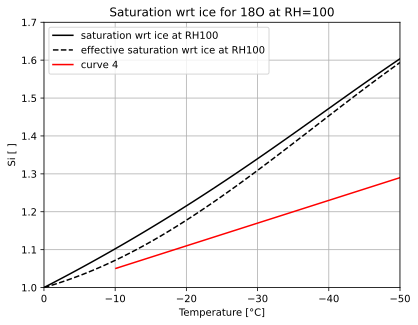

In [25]:
pyplot.plot(
    K2C(T_0_50),
    saturation_wrt_ice_at_RH100,
    'k',
    label='saturation wrt ice at RH100',
)
pyplot.plot(
    K2C(T_0_50),
    pvs_ice(T_0_50),
    'b',
    label='',
)
pyplot.plot(
    K2C(T_0_50),
    eff_saturation_wrt_ice_at_RH100,
    'k--',
    label="effective saturation wrt ice at RH100",
)
pyplot.plot(
    K2C(T_0_50)[n_points//5:],
    ice_saturation_curve_4(const,T_0_50[n_points//5:]),
    'g',
    label='curve 4',
)
pyplot.legend()
pyplot.gca().set(
    title=f"Saturation wrt ice for {isotope_considered} at RH=100",
    xlabel="Temperature [°C]",
    ylabel="Si [ ]",
    xlim=(K2C(T_0_50[0]), K2C(T_0_50[-1])),
    ylim=(1, 1.7)
)
pyplot.grid()
pyplot.legend()
show_plot('fig_8')

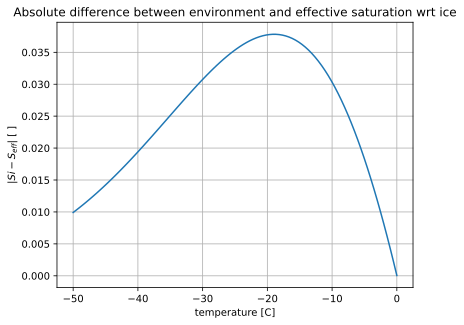

In [16]:
saturation_difference = saturation_wrt_ice_at_RH100 - eff_saturation_wrt_ice_at_RH100
pyplot.plot(K2C(T_0_50), abs(saturation_difference))
pyplot.grid()
pyplot.gca().set(
    title="Absolute difference between environment and effective saturation wrt ice",
    xlabel="temperature [C]",
    ylabel="$|Si - S_{{eff}}|$ [ ]",
)
show_plot("Si_minus_effective_Si")

## Kinetic fractionation factors

In [ ]:
pyplot.plot(K2C(T_0_50), alpha_kinetic, 'k', label="with Si")
pyplot.plot(K2C(T_0_50), eff_alpha_kinetic, 'k--', label="with effective Si")
pyplot.legend()
pyplot.gca().set(
    title="Kinetic Fractionation Factors of Temperature",
    xlabel="temperature [C]",
    ylabel="$\\alpha_{{kinetic}}$ [ ]",
)
pyplot.grid()
show_plot('alpha_kinetic_of_temperature')

## Fig. 9: Effective fractionation factors
$\alpha_{eff} = \alpha_s\alpha_k$
for $^{18}$O of saturation over ice

In [18]:
temperatures = C2K(np.array([-10., -20., -30.]))
isotope_considered = "18O"

alphas_eff = np.zeros((n_points, len(temperatures)))
Si = np.linspace(1.0, 1.4, n_points)
for i, T in enumerate(temperatures):
    alpha_s = alpha_eq[isotope_considered](T)
    alpha_k = formulae.isotope_kinetic_fractionation_factors.alpha_kinetic(
        alpha_equilibrium=alpha_s,
        saturation=Si,
        D_ratio_heavy_to_light=diffusivity_ratio[isotope_considered](T),
    )
    alphas_eff[:, i] = alpha_k * alpha_s

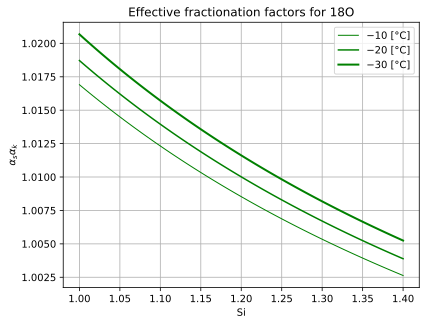

In [23]:
for i, T in enumerate(temperatures):
    pyplot.plot(
        Si,
        alphas_eff[:, i],
        'g',
        label=f'${K2C(T):.5g}$ [°C]',
        linewidth = 1 + i/2
    )
pyplot.gca().set(
    ylabel='$\\alpha_s\\alpha_k$',
    xlabel='Si',
    title = f"Effective fractionation factors for {isotope_considered}"
)
pyplot.grid()
pyplot.legend()
show_plot('fig_9')